
# PRISMA plume analysis (Hassi Messaoud, 2022-12-24)

Single-sensor plume analysis for the PRISMA acquisition over Hassi Messaoud on 2022-12-24. Mirrors the Turkmenistan multi-sensor notebook but keeps only the PRISMA matched-filter mode, mosaics, and overlays.



## 1. Setup
Import shared utilities, add the repository root to `sys.path`, and configure an output folder for intermediate clips generated during the walkthrough.


In [34]:

import os
import sys
import math
from pathlib import Path
from datetime import datetime
import numpy as np
import pandas as pd
from osgeo import gdal, ogr
from pyproj import CRS
import geopandas as gpd
import matplotlib.pyplot as plt

NOTEBOOK_ROOT = Path.cwd().resolve()
REPO_ROOT = NOTEBOOK_ROOT.parent
if str(REPO_ROOT) not in sys.path:
    sys.path.insert(0, str(REPO_ROOT))

from scripts import plumes_analyzer
from scripts.satellites import enmap_utils

plt.rcParams['figure.dpi'] = 110
CASE_NAME = "PRISMA_HassiMessaoud"
OUTPUT_BASE = NOTEBOOK_ROOT / 'outputs' / CASE_NAME
OUTPUT_BASE.mkdir(parents=True, exist_ok=True)



## 2. Configure the acquisition
Paths to the PRISMA srf-column_k1 matched-filter outputs (2022-12-24). Set `SEGMENTATION_RUN` to the timestamp produced by the detection notebook to pick up the scaled plume polygons; otherwise the legacy MF_out polygons are used.


In [35]:

BASE_DIR = Path("/mnt/d/case_studies_tanager/Hassi_Messaoud_PRISMA/20221224/jpl")
PRISMA_RUN_ID = "PRS_L1_STD_OFFL_20221224101750_20221224101755_0001_jpl"
PRISMA_CONC_FILE = BASE_DIR / f"{PRISMA_RUN_ID}_MF_concentration.tif"
PRISMA_UNC_FILE = BASE_DIR / f"{PRISMA_RUN_ID}_MF_uncertainty.tif"
PRISMA_VECTOR = BASE_DIR / "plume_segmentation_scaled/2026-01-16T22-32-08/PRS_L1_STD_OFFL_20221224101750_20221224101755_0001_jpl_MF_concentration_plumes_scaled_fixed_merged.geojson"

# Spectral cube (used for background clutter estimation)
PRISMA_L1_FILE = Path("/mnt/d/case_studies_tanager/Hassi_Messaoud_PRISMA/20221224/PRS_L1_STD_OFFL_20221224101750_20221224101755_0001.zip")

PRISMA_SPECTRAL_ASSETS = {
    "sensor": "prisma",
    "l1": PRISMA_L1_FILE,
}

GHGSAT_U_EFF_LOG_COEFF = 0.90
GHGSAT_U_EFF_OFFSET = 0.60

COMMON_WIND = {"u10": 3.0, "sigma_u10": 1.0}  # TODO: replace with case-specific wind if available

PRISMA_CASES = [
    {
        "label": "prisma_jpl_2100_srf_k1",
        "scene": "Hassi Messaoud (PRISMA JPL, 2100-2450 nm)",
        "mf_mode": "srf-column",
        "k": 1,
        "window_nm": (2100.0, 2450.0),
        "concentration_file": PRISMA_CONC_FILE,
        "uncertainty_file": PRISMA_UNC_FILE,
        "vector_path": PRISMA_VECTOR,
        "unit": "ppm-m",
        "sensor_type": "PRISMA",
        "gsd": 30,
        "wind": COMMON_WIND,
        "spectral_assets": PRISMA_SPECTRAL_ASSETS,
        "methane_windows_nm": [(2100.0, 2450.0)],
    },
]

print(f"Configured {len(PRISMA_CASES)} PRISMA cases.")
print(f"Segmentation vector path: {PRISMA_VECTOR}")


Configured 1 PRISMA cases.
Segmentation vector path: /mnt/d/case_studies_tanager/Hassi_Messaoud_PRISMA/20221224/jpl/plume_segmentation_scaled/2026-01-16T22-32-08/PRS_L1_STD_OFFL_20221224101750_20221224101755_0001_jpl_MF_concentration_plumes_scaled_fixed_merged.geojson



## 3. Lightweight reporting helper
Same reporter used in the other notebooks: it collects text blocks and figures and can optionally emit a Markdown run log alongside notebook outputs.


In [36]:

SAVE_RUN_REPORT = True
REPORT_FILE = OUTPUT_BASE / 'plume_analysis_run_report.md'
REPORT_ASSETS_DIR = OUTPUT_BASE / 'assets'

class RunReporter:
    def __init__(self, enabled, report_path, assets_dir, title='Plume Analysis Run Report'):
        self.enabled = bool(enabled)
        self.report_path = Path(report_path) if report_path else None
        self.assets_dir = Path(assets_dir) if assets_dir else None
        self.title = title
        self.sections = []
        if self.enabled and self.assets_dir:
            self.assets_dir.mkdir(parents=True, exist_ok=True)
            self._start_report()

    def _start_report(self):
        if not self.report_path:
            return
        header = f"# {self.title}\n\nGenerated: {datetime.utcnow().isoformat()}Z\n\n"
        self.report_path.write_text(header)

    def log_block(self, title, lines):
        if not self.enabled:
            return
        block = f"\n## {title}\n" + "\n".join(f"- {ln}" for ln in lines) + "\n"
        self.sections.append(block)
        if self.report_path:
            with open(self.report_path, 'a') as f:
                f.write(block)

    def log_figure(self, title, fig):
        if not (self.enabled and self.assets_dir):
            return
        safe = ''.join(ch.lower() if ch.isalnum() else '_' for ch in title).strip('_')
        asset_path = self.assets_dir / f"{safe}.png"
        fig.savefig(asset_path, dpi=150, bbox_inches='tight')
        self.log_block(title, [f"Figure: {asset_path.name}"])

    def save(self):
        if self.enabled and self.report_path:
            print(f"Report saved to {self.report_path}")

reporter = RunReporter(SAVE_RUN_REPORT, REPORT_FILE, REPORT_ASSETS_DIR, title='PRISMA Hassi Messaoud plume analysis')



## 4. Helper functions
Background estimation, plume processing, recap table, and mosaic utilities (borrowed from the Turkmenistan notebook).


In [37]:


def _rasterize_vector(vector_path, rows, cols, geo_transform, projection):
    vector_ds = ogr.Open(str(vector_path))
    if vector_ds is None:
        raise RuntimeError(f'Failed to open vector file: {vector_path}')
    layer = vector_ds.GetLayer()
    mask_ds = gdal.GetDriverByName('MEM').Create('', cols, rows, 1, gdal.GDT_Byte)
    mask_ds.SetGeoTransform(geo_transform)
    mask_ds.SetProjection(projection)
    gdal.RasterizeLayer(mask_ds, [1], layer, burn_values=[1])
    mask_array = mask_ds.ReadAsArray().astype(bool)
    mask_ds = None
    layer = None
    vector_ds = None
    return mask_array


def _load_spectral_cube(assets):
    if assets is None:
        raise ValueError('Spectral assets are required to load a cube.')
    sensor = assets.get('sensor', 'enmap').lower()
    if sensor == 'prisma':
        from scripts.satellites import prisma_utils

        cube, cw_matrix, *_ = prisma_utils.prisma_read(str(assets['l1']))
        wavelengths = np.mean(cw_matrix, axis=0).astype(np.float32)
        cube = np.rot90(cube, k=1).astype(np.float32)
        return cube, wavelengths

    cube, wavelengths, _, _, _, _ = enmap_utils.enmap_read(
        str(assets['vnir']), str(assets['swir']), str(assets['metadata'])
    )
    return cube.astype(np.float32), np.asarray(wavelengths, dtype=np.float32)


def _band_mask(wavelengths, windows, guard_nm):
    wav = np.asarray(wavelengths, dtype=float).ravel()
    mask = np.ones_like(wav, dtype=bool)
    for lo, hi in windows:
        mask &= ~((wav >= (lo - guard_nm)) & (wav <= (hi + guard_nm)))
    return mask


def _spectral_distance(cube, ref_mean, ref_std):
    standardized = (cube - ref_mean) / ref_std
    return np.sqrt(np.nanmean(standardized ** 2, axis=2))


def _select_background(distance_map, candidate_mask, percentiles, min_fraction, min_pixels, fallback_percentile=70.0):
    candidate_values = distance_map[candidate_mask]
    if candidate_values.size == 0:
        return candidate_mask & False, None, None
    min_required = max(int(np.ceil(candidate_values.size * min_fraction)), int(min_pixels))
    for perc in percentiles:
        threshold = float(np.nanpercentile(candidate_values, perc))
        mask = (distance_map <= threshold) & candidate_mask
        if mask.sum() >= min_required:
            return mask, threshold, perc
    threshold = float(np.nanpercentile(candidate_values, fallback_percentile))
    mask = (distance_map <= threshold) & candidate_mask
    return mask, threshold, fallback_percentile


def estimate_sigma_surf(
    concentration_ppm_m,
    uncertainty_ppm_m,
    geo_transform,
    projection,
    vector_path,
    spectral_assets,
    methane_windows,
    guard_nm=8.0,
    percentiles=(10, 15, 20, 30, 40, 50),
    min_fraction=0.01,
    min_pixels=750,
):
    concentration = np.asarray(concentration_ppm_m, dtype=np.float32)
    uncertainty = np.asarray(uncertainty_ppm_m, dtype=np.float32)
    finite_mask = np.isfinite(concentration) & np.isfinite(uncertainty)

    plume_mask = _rasterize_vector(vector_path, concentration.shape[0], concentration.shape[1], geo_transform, projection)
    plume_free_mask = (~plume_mask) & finite_mask

    background_mask = plume_free_mask
    background_info = {}
    try:
        cube, wavelengths = _load_spectral_cube(spectral_assets)
        usable_bands = _band_mask(wavelengths, methane_windows, guard_nm)
        if not np.any(usable_bands):
            raise ValueError('No usable bands remain after masking methane windows.')
        cube = cube[:, :, usable_bands]
        finite_cube = np.all(np.isfinite(cube), axis=2)
        ref_pixels = cube[plume_mask & finite_cube]
        if ref_pixels.size == 0:
            raise ValueError('No finite plume pixels available for spectral reference.')
        ref_mean = np.nanmedian(ref_pixels, axis=0)
        ref_std = np.nanstd(ref_pixels, axis=0, ddof=1)
        ref_std = np.where(ref_std > 0, ref_std, 1.0)
        distance_map = _spectral_distance(cube, ref_mean, ref_std)
        candidate_mask = plume_free_mask & np.isfinite(distance_map) & finite_cube
        background_mask, threshold, perc = _select_background(distance_map, candidate_mask, percentiles, min_fraction, min_pixels)
        if not np.any(background_mask):
            background_mask = plume_free_mask
        background_info = {
            'background_pixels': int(background_mask.sum()),
            'spectral_percentile': perc,
            'spectral_threshold': threshold,
        }
    except Exception as exc:
        background_info = {
            'background_pixels': int(plume_free_mask.sum()),
            'spectral_percentile': None,
            'spectral_threshold': None,
            'note': str(exc),
        }

    sigma_tot = float(np.nanstd(concentration[background_mask], ddof=1))
    sigma_rmn_sq = float(np.nanmean(np.square(uncertainty[background_mask])))
    sigma_surf = float(np.sqrt(max(0.0, sigma_tot ** 2 - sigma_rmn_sq)))
    background_info.update({'sigma_tot_ppm_m': sigma_tot, 'sigma_rmn_sq': sigma_rmn_sq})
    return sigma_surf, background_mask, plume_mask, background_info


def compute_ghgsat_u_eff(u10):
    if u10 <= 0:
        raise ValueError('U10 must be positive for the GHGSat logarithmic U_eff relationship.')
    return GHGSAT_U_EFF_LOG_COEFF * math.log(u10) + GHGSAT_U_EFF_OFFSET


def compute_ghgsat_u_eff_derivative(u10):
    if u10 <= 0:
        raise ValueError('U10 must be positive for the GHGSat logarithmic U_eff derivative.')
    return GHGSAT_U_EFF_LOG_COEFF / u10


def load_case_arrays(concentration_file, uncertainty_file):
    conc_arr, geotransform, projection, _ = plumes_analyzer.load_geotiff(str(concentration_file))
    unc_arr, _, _, _ = plumes_analyzer.load_geotiff(str(uncertainty_file))
    return conc_arr, unc_arr, geotransform, projection


def convert_units(conc_arr, unc_arr, unit):
    conc_clean = plumes_analyzer.discard_neg(conc_arr)
    unc_clean = plumes_analyzer.discard_neg(unc_arr)
    if unit == 'ppm-m':
        return plumes_analyzer.ppm_m_to_ppb(conc_clean), plumes_analyzer.ppm_m_to_ppb(unc_clean)
    return conc_clean, unc_clean


def analyze_case(case_cfg, reporter, output_dir):
    output_dir.mkdir(parents=True, exist_ok=True)
    conc_raw, unc_raw, gt, proj = load_case_arrays(case_cfg['concentration_file'], case_cfg['uncertainty_file'])
    conc_ppb, unc_ppb = convert_units(conc_raw, unc_raw, case_cfg['unit'])
    gsd = case_cfg.get('gsd') or abs(gt[1])
    sigma_surf_ppb = 0.0
    background_info = {}
    plume_mask = None

    if case_cfg['sensor_type'] in ('ENMAP', 'PRISMA'):
        sigma_surf_ppm_m, background_mask, plume_mask, background_info = estimate_sigma_surf(
            conc_raw,
            unc_raw,
            gt,
            proj,
            case_cfg['vector_path'],
            case_cfg.get('spectral_assets'),
            case_cfg.get('methane_windows_nm', [(1500.0, 1700.0), (2100.0, 2450.0)]),
        )
        sigma_surf_ppb = sigma_surf_ppm_m * 0.125
        reporter.log_block(
            f"{case_cfg['label']} background clutter",
            [
                f"sigma_tot: {background_info.get('sigma_tot_ppm_m', np.nan):.4f} ppm*m",
                f"sigma_surf: {sigma_surf_ppm_m:.4f} ppm*m ({sigma_surf_ppb:.4f} ppb)",
                f"Background pixels: {background_info.get('background_pixels', 0)}",
            ],
        )

    gdf = gpd.read_file(case_cfg['vector_path'])
    _, _, raster_wkt, _ = plumes_analyzer.load_geotiff(str(case_cfg['concentration_file']))
    raster_crs = CRS.from_wkt(raster_wkt)
    gdf_raster = gdf.to_crs(raster_crs)
    projected_gdf, projected_epsg = plumes_analyzer.project_gdf_to_local_utm(gdf)

    plumes = []
    for idx, (row_raster, row_proj) in enumerate(zip(gdf_raster.itertuples(), projected_gdf.itertuples()), start=1):
        poly = row_raster.geometry
        clip_conc_path = output_dir / f"{case_cfg['label']}_plume{idx}_conc.tif"
        clip_unc_path = output_dir / f"{case_cfg['label']}_plume{idx}_unc.tif"
        clipped_conc = plumes_analyzer.clip_raster_to_polygon(str(case_cfg['concentration_file']), poly, str(clip_conc_path))
        clipped_unc = plumes_analyzer.clip_raster_to_polygon(str(case_cfg['uncertainty_file']), poly, str(clip_unc_path))
        clipped_conc_ppb, clipped_unc_ppb = convert_units(clipped_conc, clipped_unc, case_cfg['unit'])
        clipped_unc_total_ppb = np.sqrt(np.square(clipped_unc_ppb) + sigma_surf_ppb ** 2)
        stats = plumes_analyzer.compute_plume_stats(clipped_conc_ppb)

        area_m2 = row_proj.geometry.area
        pixel_count = int(round(area_m2 / (gsd ** 2)))
        L = math.sqrt(area_m2)
        wind = case_cfg['wind']
        if case_cfg['sensor_type'] == 'GHGSAT':
            u_eff = compute_ghgsat_u_eff(wind['u10'])
            a_coeff = compute_ghgsat_u_eff_derivative(wind['u10'])
        else:
            u_eff, a_coeff, _ = plumes_analyzer.compute_u_eff(wind['u10'], case_cfg['sensor_type'])
        ime = plumes_analyzer.calculate_ime(clipped_conc_ppb, gsd)
        sigma_ime = plumes_analyzer.calculate_sigma_ime(clipped_unc_total_ppb, gsd)
        sigma_ime_instr = plumes_analyzer.calculate_sigma_ime(clipped_unc_ppb, gsd)
        sigma_ime_surf = plumes_analyzer.calculate_sigma_ime(np.full_like(clipped_unc_ppb, sigma_surf_ppb), gsd) if sigma_surf_ppb > 0 else 0.0
        q = plumes_analyzer.compute_flux(ime, u_eff, L)
        sigma_q, sigma_q_ime, sigma_q_wind = plumes_analyzer.propagate_flux_uncertainty(
            q, ime, sigma_ime, wind['u10'], wind['sigma_u10'], u_eff, a_coeff
        )

        plumes.append(
            {
                'plume_id': idx,
                'area_m2': area_m2,
                'pixel_count': pixel_count,
                'L': L,
                'u_eff': u_eff,
                'ime': ime,
                'sigma_ime': sigma_ime,
                'sigma_ime_instr': sigma_ime_instr,
                'sigma_ime_surf': sigma_ime_surf,
                'sigma_surf_ppb': sigma_surf_ppb,
                'q': q,
                'sigma_q': sigma_q,
                'sigma_q_ime': sigma_q_ime,
                'sigma_q_wind': sigma_q_wind,
                'sigma_surf_meta': background_info,
                'stats': stats,
                'clipped_conc_ppb': clipped_conc_ppb,
                'clipped_unc_ppb': clipped_unc_ppb,
                'clipped_unc_total_ppb': clipped_unc_total_ppb,
            },
        )

        reporter.log_block(
            f"{case_cfg['label']} plume {idx}",
            [
                f"Area: {area_m2:.2f} m^2 (approx {pixel_count} pixels @ {gsd} m)",
                f"IME: {ime:.2f} +/- {sigma_ime:.2f} kg",
                f"Flux: {q:.2f} +/- {sigma_q:.2f} t/h",
            ],
        )

    return {
        'label': case_cfg['label'],
        'scene': case_cfg['scene'],
        'mf_mode': case_cfg.get('mf_mode'),
        'k': case_cfg.get('k'),
        'window_nm': case_cfg.get('window_nm'),
        'sensor': case_cfg['sensor_type'],
        'unit': case_cfg['unit'],
        'gsd': gsd,
        'wind': case_cfg['wind'],
        'sigma_surf_ppb': sigma_surf_ppb,
        'background_info': background_info,
        'plumes': plumes,
        'concentration_raw': conc_raw,
        'concentration_ppb': conc_ppb,
        'uncertainty_raw': unc_raw,
        'uncertainty_ppb': unc_ppb,
        'geotransform': gt,
        'projection': proj,
        'vector_path': case_cfg['vector_path'],
        'plume_mask': plume_mask,
    }


def build_recap_table(results):
    rows = []
    for res in results:
        for plume in res['plumes']:
            rows.append(
                {
                    'sensor': res['sensor'],
                    'case': res['label'],
                    'window_nm': res.get('window_nm'),
                    'mf_mode': res.get('mf_mode'),
                    'k': res.get('k'),
                    'plume_id': plume['plume_id'],
                    'pixels': plume['pixel_count'],
                    'area_m2': plume['area_m2'],
                    'IME_kg': plume['ime'],
                    'sigma_IME_kg': plume['sigma_ime'],
                    'sigma_IME_instr_kg': plume.get('sigma_ime_instr'),
                    'sigma_IME_surf_kg': plume.get('sigma_ime_surf'),
                    'Flux_tph': plume['q'],
                    'sigma_Flux_tph': plume['sigma_q'],
                },
            )
    df = pd.DataFrame(rows)
    if not df.empty:
        ordered_cols = ['sensor', 'case', 'window_nm', 'mf_mode', 'k', 'plume_id', 'pixels', 'area_m2', 'IME_kg', 'sigma_IME_kg', 'sigma_IME_instr_kg', 'sigma_IME_surf_kg', 'Flux_tph', 'sigma_Flux_tph']
        df = df[ordered_cols]
    return df


def mosaic_plot(results, key, title, cmap='plasma', vmin=0, vmax=None, cols=3):
    n = len(results)
    cols = min(cols, n)
    rows = int(np.ceil(n / cols))
    fig, axes = plt.subplots(rows, cols, figsize=(4 * cols, 3.6 * rows))
    axes = np.atleast_2d(axes)
    flat_axes = axes.flat

    fig.subplots_adjust(left=0.05, right=0.80, top=0.92, bottom=0.06, wspace=0.08, hspace=0.08)

    vmax = vmax if vmax is not None else max(float(np.nanmax(res[key])) for res in results)
    for ax, res in zip(flat_axes, results):
        arr = res[key]
        im = ax.imshow(np.ma.masked_invalid(arr), cmap=cmap, vmin=vmin, vmax=vmax)
        label = res['label']
        if res.get('window_nm'):
            lo, hi = res['window_nm']
            label += f"{lo:.0f}-{hi:.0f} nm"
        if res.get('mf_mode'):
            label += f" | {res['mf_mode']}"
        if res.get('k'):
            label += f" k={res['k']}"
        ax.set_title(label, fontsize=9)
        ax.axis('off')

    for ax in list(flat_axes)[n:]:
        ax.axis('off')

    cax = fig.add_axes([0.83, 0.15, 0.025, 0.65])
    cbar = fig.colorbar(im, cax=cax)
    cbar.ax.set_ylabel(title)

    fig.suptitle(title, fontsize=14)
    return fig


## 5. Run the analysis
Loop through the PRISMA case, compute IME/flux with uncertainties, and keep the full-scene arrays for mosaics and overlays.


In [38]:

all_results = []

for cfg in PRISMA_CASES:
    case_dir = OUTPUT_BASE / cfg['label']
    res = analyze_case(cfg, reporter, case_dir)
    all_results.append(res)
    print(f"Processed {cfg['label']}: {len(res['plumes'])} plume(s)")

reporter.save()


/home/esivla/miniconda3/envs/hygasMF/lib/python3.11/site-packages/osgeo/gdal.py:6123: RuntimeWarning: the source raster dataset has a SRS, but the cutline features
not.  We assume that the cutline coordinates are expressed in the destination SRS.
If not, cutline results may be incorrect.
  return _gdal.wrapper_GDALWarpDestName(*args)


Processed prisma_jpl_2100_srf_k1: 2 plume(s)
Report saved to /mnt/d/Lavoro/Assegno_Ricerca_Sapienza/CLEAR_UP/CH4_detection/Matched_filter_approach/hygas/notebooks/outputs/PRISMA_HassiMessaoud/plume_analysis_run_report.md



## 6. Recap table
Areas (pixels and m^2), IME with uncertainties, and fluxes with propagated uncertainty for every plume.


In [39]:

recap_df = build_recap_table(all_results)
recap_df.style.format({
    'area_m2': '{:,.0f}',
    'IME_kg': '{:.2f}',
    'sigma_IME_kg': '{:.2f}',
    'sigma_IME_instr_kg': '{:.2f}',
    'sigma_IME_surf_kg': '{:.2f}',
    'Flux_tph': '{:.2f}',
    'sigma_Flux_tph': '{:.2f}',
}).hide(axis='index')


sensor,case,window_nm,mf_mode,k,plume_id,pixels,area_m2,IME_kg,sigma_IME_kg,sigma_IME_instr_kg,sigma_IME_surf_kg,Flux_tph,sigma_Flux_tph
PRISMA,prisma_jpl_2100_srf_k1,"(2100.0, 2450.0)",srf-column,1,1,2855,"2,569,892",820.91,19.82,19.82,0.00,3.34,0.69
PRISMA,prisma_jpl_2100_srf_k1,"(2100.0, 2450.0)",srf-column,1,2,2266,"2,039,722",504.53,15.00,15.00,0.00,2.30,0.48



## 7. Mosaics
Quick-look mosaics of concentration and uncertainty maps for the PRISMA mode.


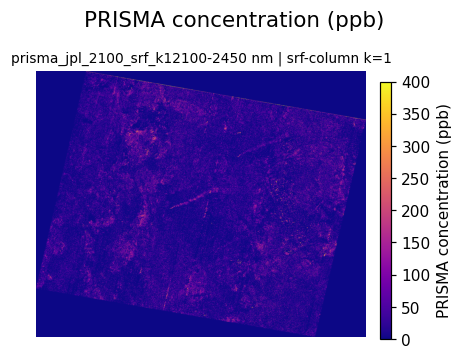

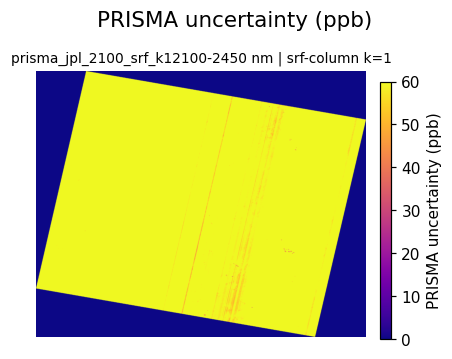

In [40]:

prisma_results = [r for r in all_results if r['sensor'] == 'PRISMA']
if prisma_results:
    fig_conc_prisma = mosaic_plot(prisma_results, 'concentration_ppb', 'PRISMA concentration (ppb)', vmin=0, vmax=400, cols=1)
    reporter.log_figure('PRISMA concentration mosaic', fig_conc_prisma)
    plt.show()

    fig_unc_prisma = mosaic_plot(prisma_results, 'uncertainty_ppb', 'PRISMA uncertainty (ppb)', vmin=0, vmax=60, cols=1)
    reporter.log_figure('PRISMA uncertainty mosaic', fig_unc_prisma)
    plt.show()



## 8. Segmented plume overlays
Zoomed concentration/uncertainty maps over the segmented plume polygons, with the plume mask outlined.


In [41]:
def _crop_with_padding(mask, pad=6):
    rows, cols = np.where(mask)
    if rows.size == 0:
        return None
    r0 = max(int(rows.min()) - pad, 0)
    r1 = min(int(rows.max()) + pad + 1, mask.shape[0])
    c0 = max(int(cols.min()) - pad, 0)
    c1 = min(int(cols.max()) + pad + 1, mask.shape[1])
    return r0, r1, c0, c1


def _auto_vmax(arr, pct=90.0):
    if arr.size == 0:
        return None
    vmax = float(np.nanpercentile(arr, pct))
    if not np.isfinite(vmax) or vmax <= 0:
        vmax = float(np.nanmax(arr)) if np.isfinite(np.nanmax(arr)) else None
    return vmax if vmax and vmax > 0 else None


def plot_segmented_overlays(results, reporter=None, vmin_conc=0, vmin_unc=0, padding=6, pct=99.0):
    for res in results:
        vector_path = res.get('vector_path')
        mask = res.get('plume_mask')
        conc_map = res.get('concentration_ppb', res.get('concentration_raw'))
        unc_map = res.get('uncertainty_ppb', res.get('uncertainty_raw'))
        if conc_map is None or unc_map is None:
            continue
        if mask is None and vector_path is not None:
            mask = _rasterize_vector(
                vector_path,
                conc_map.shape[0],
                conc_map.shape[1],
                res['geotransform'],
                res['projection'],
            )
        if mask is None or not np.any(mask):
            continue
        bbox = _crop_with_padding(mask, pad=padding)
        if bbox is None:
            continue
        r0, r1, c0, c1 = bbox
        conc = conc_map[r0:r1, c0:c1]
        unc = unc_map[r0:r1, c0:c1]
        mask_crop = mask[r0:r1, c0:c1]
        conc_vmax = _auto_vmax(conc, pct=pct)
        unc_vmax = _auto_vmax(unc, pct=pct)
        fig, axes = plt.subplots(1, 2, figsize=(10, 4))
        im0 = axes[0].imshow(np.ma.masked_invalid(conc), cmap='plasma', vmin=vmin_conc, vmax=300)
        axes[0].contour(mask_crop, levels=[0.5], colors='cyan', linewidths=0.5)
        axes[0].set_title(f"{res['label']} (concentration ppb)")
        plt.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.06)
        im1 = axes[1].imshow(np.ma.masked_invalid(unc), cmap='magma', vmin=vmin_unc, vmax=unc_vmax)
        axes[1].contour(mask_crop, levels=[0.5], colors='cyan', linewidths=0.5)
        axes[1].set_title(f"{res['label']} (uncertainty ppb)")
        plt.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.06)
        for ax in axes:
            ax.axis('off')
        fig.suptitle(res['scene'], fontsize=12)
        if reporter is not None:
            reporter.log_figure(f"{res['label']}_plume_overlay", fig)
        plt.tight_layout()
        plt.show()


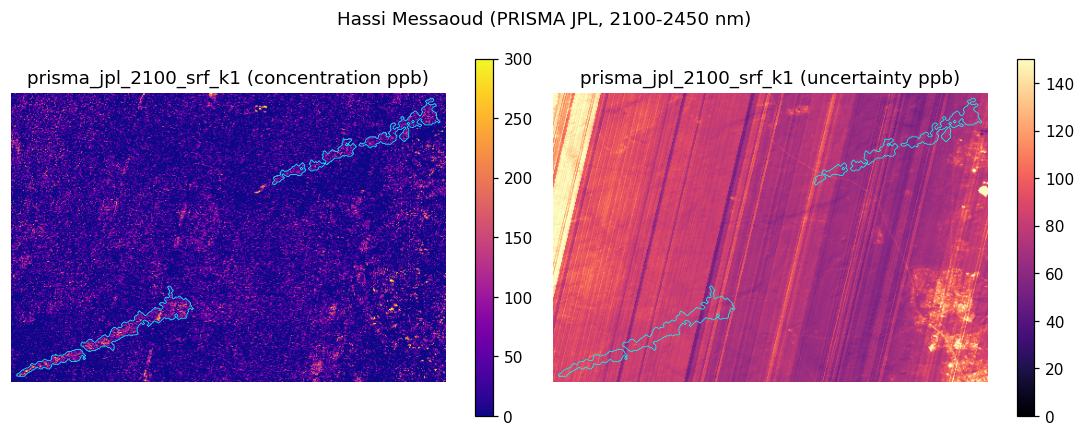

In [42]:
plot_segmented_overlays(all_results, reporter=reporter)

/tmp/ipykernel_16952/1547393163.py:140: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0.02, 0.05, 0.82, 0.95])


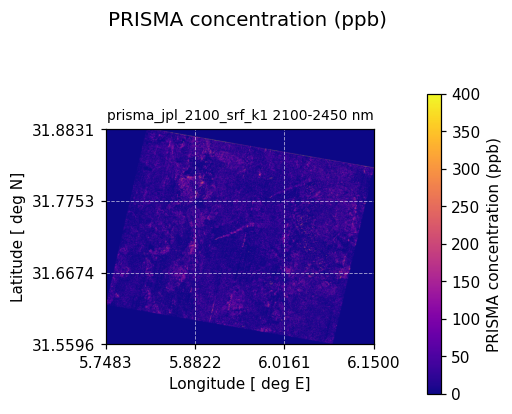

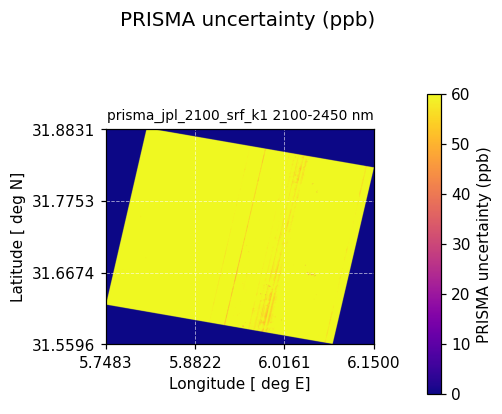

In [43]:

import matplotlib.ticker as mticker
import rasterio
from rasterio.transform import Affine, array_bounds
from rasterio.warp import reproject, Resampling
from rasterio.crs import CRS as RioCRS
from rasterio.windows import Window, transform as window_transform

def _to_affine(gt):
    return Affine.from_gdal(*gt)

if not all_results:
    raise RuntimeError("No PRISMA results available for reprojection.")

ref_res = all_results[0]
ref_h, ref_w = ref_res['concentration_ppb'].shape
ref_transform = _to_affine(ref_res['geotransform'])
ref_crs = RioCRS.from_wkt(ref_res['projection'])

def _window_extent(window):
    r0, r1, c0, c1 = window
    win = Window.from_slices((r0, r1), (c0, c1))
    win_transform = window_transform(win, ref_transform)
    west, south, east, north = array_bounds(int(win.height), int(win.width), win_transform)
    return (west, east, south, north)

def _set_lonlat_grid(ax, extent):
    west, east, south, north = extent
    ax.set_xticks(np.linspace(west, east, 4))
    ax.set_yticks(np.linspace(south, north, 4))
    ax.xaxis.set_major_formatter(mticker.FormatStrFormatter('%.4f'))
    ax.yaxis.set_major_formatter(mticker.FormatStrFormatter('%.4f'))
    ax.set_xlabel('Longitude [ deg E]')
    ax.set_ylabel('Latitude [ deg N]')
    ax.grid(True, linestyle='--', color='white', alpha=0.6, linewidth=0.6)

def _reproject_array(arr, src_gt, src_proj, resampling):
    dst = np.full((ref_h, ref_w), np.nan, dtype=np.float32)
    reproject(
        source=np.where(np.isfinite(arr), arr, np.nan),
        destination=dst,
        src_transform=_to_affine(src_gt),
        src_crs=RioCRS.from_wkt(src_proj),
        dst_transform=ref_transform,
        dst_crs=ref_crs,
        resampling=resampling,
        dst_nodata=np.nan,
    )
    return dst

def _reproject_mask(res):
    mask = res.get('plume_mask')
    if mask is None and res.get('vector_path'):
        mask = _rasterize_vector(
            res['vector_path'],
            res['concentration_ppb'].shape[0],
            res['concentration_ppb'].shape[1],
            res['geotransform'],
            res['projection'],
        )
    if mask is None:
        return None
    dst = np.zeros((ref_h, ref_w), dtype=np.uint8)
    reproject(
        source=mask.astype(np.uint8),
        destination=dst,
        src_transform=_to_affine(res['geotransform']),
        src_crs=RioCRS.from_wkt(res['projection']),
        dst_transform=ref_transform,
        dst_crs=ref_crs,
        resampling=Resampling.nearest,
        dst_nodata=0,
    )
    return dst.astype(bool)

# Reproject every product to the reference grid
REPROJECTED = {}
for res in all_results:
    conc_src = res.get('concentration_ppb', res['concentration_raw'])
    unc_src = res.get('uncertainty_ppb', res['uncertainty_raw'])
    REPROJECTED[res['label']] = {
        'conc': _reproject_array(conc_src, res['geotransform'], res['projection'], Resampling.bilinear),
        'unc': _reproject_array(unc_src, res['geotransform'], res['projection'], Resampling.bilinear),
        'mask': _reproject_mask(res),
        'meta': res,
    }

# Common valid window (intersection of finite pixels)
common_valid = np.ones((ref_h, ref_w), dtype=bool)
for val in REPROJECTED.values():
    common_valid &= np.isfinite(val['conc'])
if common_valid.any():
    rr, cc = np.where(common_valid)
    PLOT_WINDOW = (rr.min(), rr.max() + 1, cc.min(), cc.max() + 1)
else:
    PLOT_WINDOW = (0, ref_h, 0, ref_w)
PLOT_EXTENT = _window_extent(PLOT_WINDOW)

def mosaic_plot_common(results, key, title, cmap='plasma', vmin=0, vmax=None, cols=3):
    n = len(results)
    cols = min(cols, n)
    rows = int(np.ceil(n / cols))
    fig, axes = plt.subplots(rows, cols, figsize=(4.8 * cols, 4.2 * rows))
    axes = np.atleast_2d(axes)
    r0, r1, c0, c1 = PLOT_WINDOW

    if vmax is None:
        vmax_vals = []
        for res in results:
            arr = REPROJECTED[res['label']][key]
            finite = arr[np.isfinite(arr)]
            if finite.size:
                vmax_vals.append(np.nanpercentile(finite, 99))
        vmax = float(np.nanmax(vmax_vals)) if vmax_vals else None

    im = None
    for ax, res in zip(axes.flat, results):
        arr = REPROJECTED[res['label']][key][r0:r1, c0:c1]
        im = ax.imshow(
            np.ma.masked_invalid(arr),
            cmap=cmap,
            vmin=vmin,
            vmax=vmax,
            extent=PLOT_EXTENT,
            origin='upper',
        )
        lbl = res['label']
        if res.get('window_nm'):
            lo, hi = res['window_nm']
            lbl += f' {lo:.0f}-{hi:.0f} nm'
        ax.set_title(lbl, fontsize=9)
        _set_lonlat_grid(ax, PLOT_EXTENT)
        ax.set_aspect('equal')

    for ax in list(axes.flat)[n:]:
        ax.axis('off')

    cax = fig.add_axes([0.84, 0.15, 0.025, 0.65])
    fig.colorbar(im, cax=cax, label=title)
    fig.suptitle(title, fontsize=13)
    fig.tight_layout(rect=[0.02, 0.05, 0.82, 0.95])
    return fig

prisma_results = all_results
if prisma_results:
    fig_conc_prisma = mosaic_plot_common(prisma_results, 'conc', 'PRISMA concentration (ppb)', vmin=0, vmax=400, cols=1)
    reporter.log_figure('PRISMA concentration mosaic (geo)', fig_conc_prisma)
    plt.show()

    fig_unc_prisma = mosaic_plot_common(prisma_results, 'unc', 'PRISMA uncertainty (ppb)', vmin=0, vmax=60, cols=1)
    reporter.log_figure('PRISMA uncertainty (geo)', fig_unc_prisma)
    plt.show()


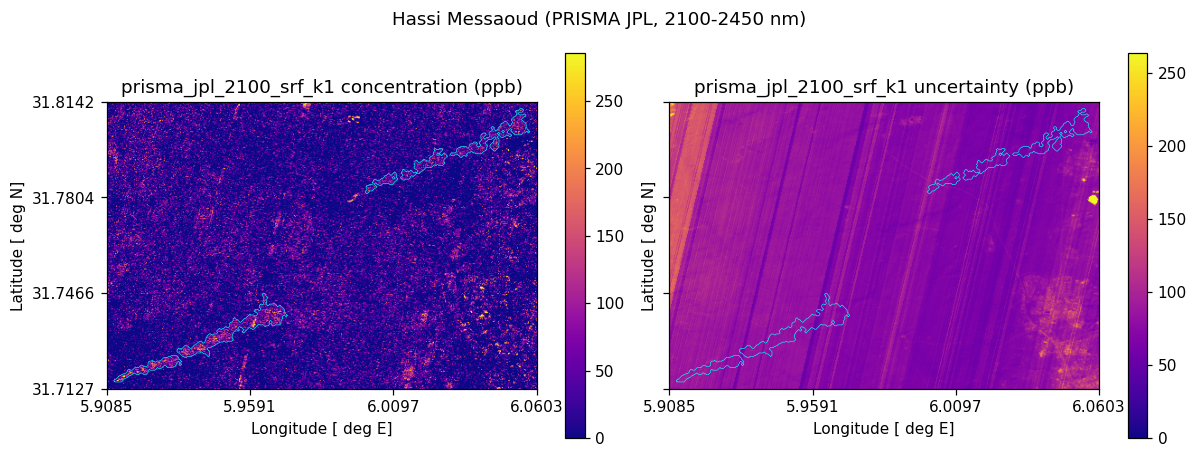

In [49]:

import matplotlib.ticker as mticker

orig_plot_window, orig_plot_extent = PLOT_WINDOW, PLOT_EXTENT

def compute_plume_window(pad=8):
    mask_union = np.zeros((ref_h, ref_w), dtype=bool)
    for val in REPROJECTED.values():
        m = val.get('mask')
        if m is not None:
            mask_union |= m
    if not mask_union.any():
        return orig_plot_window, orig_plot_extent
    rows, cols = np.where(mask_union)
    r0 = max(rows.min() - pad, 0)
    r1 = min(rows.max() + pad + 1, ref_h)
    c0 = max(cols.min() - pad, 0)
    c1 = min(cols.max() + pad + 1, ref_w)
    win = (r0, r1, c0, c1)
    return win, _window_extent(win)

# Adjust pad here to zoom more/less
PLOT_WINDOW, PLOT_EXTENT = compute_plume_window(pad=8)

# Global vmax across all mosaics (99th percentile)
def _global_vmax(key, pct=99):
    vals = []
    for r in REPROJECTED.values():
        finite = r[key][np.isfinite(r[key])]
        if finite.size:
            vals.append(np.nanpercentile(finite, pct))
    return float(np.nanmax(vals)) if vals else None

GLOBAL_VMAX_CONC = _global_vmax('conc', pct=99.95)
GLOBAL_VMAX_UNC  = _global_vmax('unc',  pct=99.95)
POLY_COLOR = 'cyan'  # change this to set contour color

def plot_segmented_overlays_common(
    results,
    reporter=None,
    vmin_conc=0,
    vmin_unc=0,
    vmax_conc=None,
    vmax_unc=None,
    pct=99.0,
    poly_color=POLY_COLOR,
):
    r0, r1, c0, c1 = PLOT_WINDOW
    extent = PLOT_EXTENT
    west, east, south, north = extent

    def _auto_vmax_local(arr, pct=99.0):
        if arr.size == 0:
            return None
        vmax = float(np.nanpercentile(arr, pct))
        if not np.isfinite(vmax) or vmax <= 0:
            vmax = float(np.nanmax(arr)) if np.isfinite(np.nanmax(arr)) else None
        return vmax if vmax and vmax > 0 else None

    def _lonlat_ticks(ax):
        ax.set_xticks(np.linspace(west, east, 4))
        ax.set_yticks(np.linspace(south, north, 4))
        ax.xaxis.set_major_formatter(mticker.FormatStrFormatter('%.4f'))
        ax.yaxis.set_major_formatter(mticker.FormatStrFormatter('%.4f'))
        ax.tick_params(direction='out', length=4, width=0.8, colors='black')
        ax.set_xlabel('Longitude [ deg E]')
        ax.set_ylabel('Latitude [ deg N]')
        ax.grid(False)

    # Coordinates for contour alignment with origin='upper'
    x_coords = np.linspace(west, east, c1 - c0)
    y_coords = np.linspace(north, south, r1 - r0)

    for res in results:
        data = REPROJECTED[res['label']]
        conc = data['conc'][r0:r1, c0:c1]
        unc = data['unc'][r0:r1, c0:c1]
        mask = data.get('mask')
        mask_crop = mask[r0:r1, c0:c1] if mask is not None else np.isfinite(conc)

        conc_vmax = vmax_conc if vmax_conc is not None else _auto_vmax_local(conc, pct=pct)
        unc_vmax  = vmax_unc  if vmax_unc  is not None else _auto_vmax_local(unc,  pct=pct)

        fig, axes = plt.subplots(1, 2, figsize=(11, 4.2), sharex=True, sharey=True)

        im0 = axes[0].imshow(
            np.ma.masked_invalid(conc),
            cmap='plasma',
            vmin=vmin_conc,
            vmax=conc_vmax,
            extent=extent,
            origin='upper',
        )
        axes[0].contour(
            x_coords,
            y_coords,
            mask_crop.astype(float),
            levels=[0.5],
            colors=poly_color,
            linewidths=0.4,
        )
        axes[0].set_title(f"{res['label']} concentration (ppb)")
        plt.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.06)

        im1 = axes[1].imshow(
            np.ma.masked_invalid(unc),
            cmap='plasma',
            vmin=vmin_unc,
            vmax=unc_vmax,
            extent=extent,
            origin='upper',
        )
        axes[1].contour(
            x_coords,
            y_coords,
            mask_crop.astype(float),
            levels=[0.5],
            colors=poly_color,
            linewidths=0.4,
        )
        axes[1].set_title(f"{res['label']} uncertainty (ppb)")
        plt.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.06)

        for ax in axes:
            ax.set_aspect('equal')
            _lonlat_ticks(ax)

        fig.suptitle(res['scene'], fontsize=12)
        fig.tight_layout()
        if reporter is not None:
            reporter.log_figure(f"{res['label']}_plume_overlay_geo", fig)
        plt.show()

# Run overlays with shared vmax across mosaics
plot_segmented_overlays_common(
    all_results,
    reporter=reporter,
    vmin_conc=0,
    vmin_unc=0,
    vmax_conc=GLOBAL_VMAX_CONC,
    vmax_unc=GLOBAL_VMAX_UNC,
    pct=99.0,
    poly_color=POLY_COLOR,
)
